In [1]:
# -*- coding: utf-8 -*-
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 10,8

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [2]:
reward_table = [
    [ -250 , -8888, -405 , -8888],
    [-309 , -8888, -400 , 405  ],
    [-262 , -8888, -255 , 400  ],
    [-231 , -8888, -77  , 255  ],
    [-61  , -8888, 0    , 77   ],
    [0    , -8888, 0    , 0    ],
    [0    , -8888, -8888, 0    ],
    [-325 , 250  , -452 , -8888],
    [-270 , 309  , -325 , 452  ],
    [-200 , 262  , -190 , 325  ],
    [-125 , 231  , -10  , 190  ],
    [-2   , 61   , 0    , 10   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -8888, 0    ],
    [-192 , 325  , -390 , -8888],
    [-169 , 270  , -285 , -390 ],
    [-105 , 200  , -132 , 285  ],
    [-10  , 125  , -5   , 132  ],
    [0    , 2    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -8888, 0    ],
    [-117 , 192  , -350 , -8888],
    [-67  , 169  , -235 , 350  ],
    [-8   , 105  , -26  , 235  ],
    [0    , 10   , 0    , 26   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -8888, 0    ],
    [-38  , 117  , -250 , -8888],
    [0    , 67   , -148 , 250  ],
    [0    , 8    , -3   , 148  ],
    [0    , 0    , 0    , 3    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -8888, 0    ],
    [0    , 38   , -195 , -8888],
    [0    , 0    , -193 , 195  ],
    [0    , 0    , -5   , 193  ],
    [0    , 0    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -8888, 0    ],
    [-8888, 0    , -255 , -8888],
    [-8888, 0    , -190 , 255  ],
    [-8888, 0    , -8   , 190  ],
    [-8888, 0    , 0    , 8   ],
    [-8888, 0    , 0    , 0    ],
    [-8888, 0    , 0    , 0    ],
    [-8888, 0    , -8888, 0    ]
]; 

In [3]:
def action_is_allowed(learner, state, action):

    if (action == 0 and not(state > learner.num_states - learner.servo_num_states - 1)):
        return True
    elif (action == 1 and not(state < learner.servo_num_states)):
        return True
    elif (action == 2 and not((state%learner.servo_num_states) == (learner.servo_num_states-1))):
        return True
    elif (action == 3 and not(state%learner.servo_num_states==0)):
        return True
    else:
        return False

In [4]:
class QLearner(object):
    def __init__(self, servo_num_states, num_actions, alpha, gamma, random_action_rate, random_action_decay_rate, warm_up_period):
        
        self.servo_num_states = servo_num_states
        self.num_states = servo_num_states**2
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.random_action_rate = random_action_rate
        self.random_action_decay_rate = random_action_decay_rate
        self.warm_up_period = warm_up_period
        self.state = 0
        self.action = 0
        #self.qtable = np.random.uniform(low=-1, high=1, size=(self.num_states, self.num_actions))
        self.qtable = np.zeros((self.num_states, self.num_actions))
        self.num_iteration = 0
    def set_initial_state(self, action):
        """
        @summary: Sets the initial state and returns an action
        @param state: The initial state
        @returns: The selected action
        """
        self.state = int(self.num_states/2)
        self.action = action #self.qtable[state].argsort()[-1]
        
    def get_next_state(self):
        
        next_state = None
        
        if (self.action == 0 and action_is_allowed(self, self.state, self.action)): 
            next_state = self.state + self.servo_num_states
        elif (self.action == 1 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - self.servo_num_states
        elif (self.action == 2 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state + 1
        elif (self.action == 3 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - 1 
        else:
            next_state = self.state;
            
        return next_state
        
    def move(self, state_prime, reward):
        """
        @summary: Moves to the given state with given reward and returns action
        @param state_prime: The new state
        @param reward: The reward
        @returns: The selected action
        """
        alpha = self.alpha
        gamma = self.gamma
        state = self.state
        action = self.action
        qtable = self.qtable
        action_prime = -1
        
#         if self.state == state_prime: 

#             while not self.action_is_allowed(action_prime):
#                 action_prime = np.random.randint(0, self.num_actions)
            
#             self.action = action_prime
            
        if False:
            print 'yo'
            
        else: 
            
            choose_random_action = (1 - self.random_action_rate) <= np.random.uniform(0, 1)

            if choose_random_action:
#                 while not(action_is_allowed(self, state_prime, action_prime)): 
                action_prime = np.random.randint(0, self.num_actions)
            else:
                ordered_action_list = self.qtable[state_prime].argsort()
                best_choice_index = -1
#                 while not(action_is_allowed(self, state_prime, action_prime)):
                action_prime = ordered_action_list[best_choice_index]
#                     best_choice_index -= 1

            if self.num_iteration > self.warm_up_period: # warm up period is over
                self.random_action_rate *= self.random_action_decay_rate
            
#             if reward > 0 :
#                 reward = reward * 2
                
            qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * qtable[state_prime, action_prime] - qtable[state, action])

            self.state = state_prime
            self.action = action_prime    
            self.qtable = qtable

In [6]:
def get_final_reward(learner, reward_table, training_iteration, num_simulation):
    
    reward_list = []
    
    for simulation in xrange(num_simulation):
        
        temp_reward_list = []
    
        for iteration_step in xrange(training_iteration):

            reward = reward_table[learner.state][learner.action] - 10

            temp_reward_list.append(reward)

            next_state = learner.get_next_state()


            learner.move(next_state, reward)
            learner.num_iteration += 1 

        reward_list.append(np.sum(temp_reward_list))

    return np.mean(reward_list)
    
    

In [7]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

best_score = np.inf

def score(params):
    
    global best_score    

    learner = QLearner(servo_num_states=7,
                       num_actions=4,
                       alpha=float(params['alpha']),
                       gamma=float(params['gamma']),
                       random_action_rate=float(params['random_action_rate']),
                       random_action_decay_rate=float(params['random_action_decay_rate']),
                       warm_up_period=int(params['warm_up_period']))

    learner.set_initial_state(action=0)

    loss = - get_final_reward(learner, reward_table, training_iteration=10000, num_simulation=100) # negative because we want to minimize loss
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.2f}".format(loss), 
        print params 
        print 
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0, 1),
             'gamma': hp.uniform('gamma', 0, 1),
             'random_action_rate': hp.uniform('random_action_rate', 0.8, 1), 
             'random_action_decay_rate': hp.uniform('random_action_decay_rate', 0.1, 1),
             'warm_up_period': hp.quniform('warm_up_period', 1, 2000, 1)
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [8]:
%%time

#Trials object where the history of search will be stored
trials = Trials()

best_params = optimize(trials)

Searching... New best score: -114575.80 {'random_action_rate': 0.8408710004050584, 'warm_up_period': 894.0, 'gamma': 0.9539628710394158, 'random_action_decay_rate': 0.10262091235770437, 'alpha': 0.41866858155212605}

Searching... New best score: -152128.83 {'random_action_rate': 0.9194790752773793, 'warm_up_period': 411.0, 'gamma': 0.9983428855456454, 'random_action_decay_rate': 0.4645789085705596, 'alpha': 0.7375311896663116}

Searching... New best score: -166520.65 {'random_action_rate': 0.9353890876785266, 'warm_up_period': 355.0, 'gamma': 0.9921270856048059, 'random_action_decay_rate': 0.24581687870776198, 'alpha': 0.6493734074100681}

------------------------
Done.
Best parameter setting: {'warm_up_period': 355.0, 'random_action_decay_rate': 0.24581687870776198, 'random_action_rate': 0.9353890876785266, 'gamma': 0.9921270856048059, 'alpha': 0.6493734074100681}
CPU times: user 18min 56s, sys: 7.48 s, total: 19min 4s
Wall time: 19min 23s


  1%|          | 11/1000 [00:01<02:13,  7.41it/s]

7 2 [-5245.40966894  -790.83005196  -705.45210176 -7804.08871188]
8 2 [-334.43036552 -332.51962901 -245.38347449 -333.61152983]
9 1 [-162.89288411   90.32818141 -129.87468148   -3.23272497]
2 3 [ -255.97722663 -7804.08871188  -247.90002591  -162.95423395]
1 3 [ -642.49986227 -7804.08871188  -645.63205386  -557.34162799]
0 0 [ -959.89831687 -7912.8638526  -1044.59112318 -7804.08871188]
7 2 [-5245.40966894  -790.83005196  -705.45177035 -7804.08871188]
8 2 [-334.43036552 -332.51962901 -245.3831434  -333.61152983]
9 1 [-162.89288411   90.32851218 -129.87468148   -3.23272497]
2 3 [ -255.97722663 -7804.08871188  -247.90002591  -162.95390349]
1 3 [ -642.49986227 -7804.08871188  -645.63205386  -557.34129785]
0 0 [ -959.89798704 -7912.8638526  -1044.59112318 -7804.08871188]
7 2 [-5245.40966894  -790.83005196  -705.45144084 -7804.08871188]
8 2 [-334.43036552 -332.51962901 -245.38281421 -333.61152983]
9 1 [-162.89288411   90.32884106 -129.87468148   -3.23272497]
2 3 [ -255.97722663 -7804.08871188

100%|██████████| 1000/1000 [02:11<00:00,  7.68it/s]


[ 23.35835  23.40797  26.5582   26.67548]


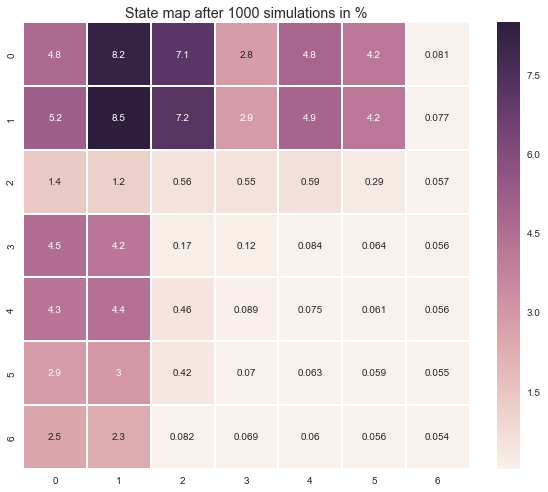

In [9]:
def crawling_simulation(params, reward_table, training_iteration = 10000, num_simulation = 1000):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    
    for simulation in tqdm(xrange(num_simulation)):
        
        learner = QLearner(servo_num_states = 7,
                           num_actions = 4,
                           alpha = params['alpha'],
                           gamma = params['gamma'],
                           random_action_rate = params['random_action_rate'],
                           random_action_decay_rate = params['random_action_decay_rate'],
                           warm_up_period = params['warm_up_period'])

        learner.set_initial_state(action=0)

        stop = False
    
        for iteration_step in xrange(training_iteration):
            
#             if learner.num_iteration == 1000:
#                 print learner.qtable[0]

            
            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 
            
            if iteration_step >= 9980 and simulation == 9:
                print learner.state, learner.action, learner.qtable[learner.state]

            reward = reward_table[learner.state][learner.action] - 10
            next_state = learner.get_next_state()
            
#             dup = False
#             if next_state == learner.state:
#                 dup = True
#                 print iteration_step, next_state, learner.action, reward, 

            learner.move(next_state, reward)
            learner.num_iteration += 1 
#             if dup:
#                 print next_state
#                 print learner.qtable[next_state]
#                 print '----'

        
    normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
    state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
    sns.heatmap(state_map, linewidths=1, annot=True)
    plt.title('State map after {} simulations in %'.format(num_simulation))
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.
    
    print normalize_action_vector
    
    return learner

learner = crawling_simulation(best_params, reward_table)